In [32]:
# Josh Burgess
# 300652214

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.models as models
from transformers import ViTForImageClassification
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import matplotlib.pyplot as plt
import seaborn as sns

# Check for GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


In [2]:
# Load pre-trained models for binary pneumonia classification

# Load ResNet-50 (CNN baseline)
print("Loading ResNet-50:")
resnet = models.resnet50(pretrained=True)
# Modify final layer for binary classification
resnet.fc = nn.Linear(resnet.fc.in_features, 2)
resnet = resnet.to(device)

# Load ViT-Base (ViT baseline)
print("Loading ViT-Base:")
vit = ViTForImageClassification.from_pretrained(
    'google/vit-base-patch16-224',
    num_labels=2,
    ignore_mismatched_sizes=True
)
vit = vit.to(device)

print(f"ResNet-50 final layer: {resnet.fc}")
print(f"ViT classifier: {vit.classifier}")

Loading ResNet-50:


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 160MB/s]


Loading ViT-Base:


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ResNet-50 final layer: Linear(in_features=2048, out_features=2, bias=True)
ViT classifier: Linear(in_features=768, out_features=2, bias=True)


In [3]:
# Train a model and return training history

def train_model(model, train_loader, val_loader, num_epochs=5, learning_rate=1e-4):

    # Set up loss function and optimiser
    criterion = nn.CrossEntropyLoss()
    optimiser = optim.Adam(model.parameters(), lr=learning_rate)

    # Store training metrics over time
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        # Process each batch of training data
        for batch_idx, (images, labels) in enumerate(train_loader):
            # Move data to GPU/CPU device
            images, labels = images.to(device), labels.to(device)

            optimiser.zero_grad()

            if hasattr(model, 'classifier') and 'ViT' in str(type(model)):
                # ViT returns ImageClassifierOutput, need to extract logits
                outputs = model(images).logits

            else:
                # ResNet returns tensor directly
                outputs = model(images)

            loss = criterion(outputs, labels) # Calc loss between predictions and true labels
            loss.backward() # Backward pass (calc gradients)
            optimiser.step() # Update model weights based on gradients

            train_loss += loss.item()

            # Calc training accuracy
            _, predicted = torch.max(outputs, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

            if batch_idx % 5 == 0:  # Print every 5 batches
                print(f'Epoch {epoch+1}/{num_epochs}, Batch {batch_idx}/{len(train_loader)}, Loss: {loss.item():.4f}')


        # Calculate training accuracy for this epoch
        train_acc = 100 * train_correct / train_total

        # Validation phase
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        # Evaluate without updating weights
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)

                if hasattr(model, 'classifier') and 'ViT' in str(type(model)):
                    # ViT returns ImageClassifierOutput, need to extract logits
                    outputs = model(images).logits


                else:
                    # ResNet returns tensor directly
                    outputs = model(images)

                loss = criterion(outputs, labels)
                val_loss += loss.item()

                # Calculate accuracy
                max_values, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        # Calculate average metrics for this epoch
        train_loss /= len(train_loader)
        val_loss /= len(val_loader)
        val_acc = 100 * correct / total

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)

        print(f'Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')

    return history

In [4]:
# For google colab integration
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir('/content/drive/MyDrive/AIML339/Project/Code')
print(os.listdir('.'))  # Should now show your .py files

Mounted at /content/drive
['model_implementation.ipynb', 'archive.zip', 'data_exploration.ipynb', 'data_preprocessing.ipynb', 'chest_xray', '__pycache__', 'data_utils.py', 'dataset.py']


In [5]:
# Import
from data_utils import create_splits, get_train_val_splits, get_transforms
from dataset import create_data_loaders, create_subset_loader

# Load and split your data
print("Loading chest X-ray data...")
normal_files, pneumonia_files = create_splits()
normal_train, normal_val, pneumonia_train, pneumonia_val = get_train_val_splits(normal_files, pneumonia_files)

# Get transforms
train_transform, val_transform = get_transforms()

# Create data loaders
train_loader, val_loader = create_data_loaders(
    normal_train, normal_val, pneumonia_train, pneumonia_val,
    train_transform, val_transform, batch_size=32
)

# Create 500-image subset for testing
subset_loader = create_subset_loader(normal_train, pneumonia_train, train_transform)

print(f"Training samples: {len(normal_train) + len(pneumonia_train)}")
print(f"Validation samples: {len(normal_val) + len(pneumonia_val)}")
print(f"Subset samples: {len(subset_loader.dataset)}")

Loading chest X-ray data...
Training samples: 4185
Validation samples: 1047
Subset samples: 500


In [ ]:
# Test training on small subset
print("Training ResNet-50 on 500-image subset")
resnet_history = train_model(resnet, subset_loader, subset_loader, num_epochs=2, learning_rate=1e-4)

print("\nTraining ViT on 500-image subset")
vit_history = train_model(vit, subset_loader, subset_loader, num_epochs=2, learning_rate=1e-4)

print(f"ResNet final validation accuracy: {resnet_history['val_acc'][-1]:.2f}%")
print(f"ViT final validation accuracy: {vit_history['val_acc'][-1]:.2f}%")

In [6]:
# Create whole dataset with proper train/val splits
print("Scaling to whole dataset")

# Create whole data loaders (not using subset anymore)
whole_train_loader, whole_val_loader = create_data_loaders(
    normal_train, normal_val, pneumonia_train, pneumonia_val,
    train_transform, val_transform, batch_size=32
)

print(f"Whole training batches: {len(whole_train_loader)}")
print(f"Whole validation batches: {len(whole_val_loader)}")
print(f"Training samples: {len(whole_train_loader.dataset)}")
print(f"Validation samples: {len(whole_val_loader.dataset)}")

# Test one batch to ensure everything works
test_batch = next(iter(whole_train_loader))
print(f"Batch shape: {test_batch[0].shape}")
print(f"Labels shape: {test_batch[1].shape}")

Scaling to whole dataset
Whole training batches: 131
Whole validation batches: 33
Training samples: 4185
Validation samples: 1047
Batch shape: torch.Size([32, 3, 224, 224])
Labels shape: torch.Size([32])


In [7]:
# Train ResNet-50 on whole dataset
print("Training ResNet-50 on whole dataset...")
resnet_whole_history = train_model(
    resnet,
    whole_train_loader,
    whole_val_loader,
    num_epochs=10,
    learning_rate=1e-4
)

print("\nTraining ViT on whole dataset...")
vit_whole_history = train_model(
    vit,
    whole_train_loader,
    whole_val_loader,
    num_epochs=10,
    learning_rate=1e-4
)

print(f"ResNet final training accuracy: {resnet_whole_history['train_acc'][-1]:.2f}%")
print(f"ResNet final validation accuracy: {resnet_whole_history['val_acc'][-1]:.2f}%")
print(f"ViT final training accuracy: {vit_whole_history['train_acc'][-1]:.2f}%")
print(f"ViT final validation accuracy: {vit_whole_history['val_acc'][-1]:.2f}%")

Training ResNet-50 on whole dataset...
Epoch 1/10, Batch 0/131, Loss: 0.6939
Epoch 1/10, Batch 5/131, Loss: 0.2274
Epoch 1/10, Batch 10/131, Loss: 0.1310
Epoch 1/10, Batch 15/131, Loss: 0.1716
Epoch 1/10, Batch 20/131, Loss: 0.0539
Epoch 1/10, Batch 25/131, Loss: 0.0410
Epoch 1/10, Batch 30/131, Loss: 0.0520
Epoch 1/10, Batch 35/131, Loss: 0.1877
Epoch 1/10, Batch 40/131, Loss: 0.0357
Epoch 1/10, Batch 45/131, Loss: 0.0585
Epoch 1/10, Batch 50/131, Loss: 0.1246
Epoch 1/10, Batch 55/131, Loss: 0.0417
Epoch 1/10, Batch 60/131, Loss: 0.0441
Epoch 1/10, Batch 65/131, Loss: 0.2044
Epoch 1/10, Batch 70/131, Loss: 0.0159
Epoch 1/10, Batch 75/131, Loss: 0.1940
Epoch 1/10, Batch 80/131, Loss: 0.0174
Epoch 1/10, Batch 85/131, Loss: 0.1077
Epoch 1/10, Batch 90/131, Loss: 0.0986
Epoch 1/10, Batch 95/131, Loss: 0.0516
Epoch 1/10, Batch 100/131, Loss: 0.0285
Epoch 1/10, Batch 105/131, Loss: 0.0318
Epoch 1/10, Batch 110/131, Loss: 0.0074
Epoch 1/10, Batch 115/131, Loss: 0.0641
Epoch 1/10, Batch 120/1

In [33]:
def plot_confusion_matrix(cm, model_name, classes=['Normal', 'Pneumonia']):

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=classes, yticklabels=classes,
                cbar_kws={'label': 'Count'})
    
    plt.title(f'{model_name} - Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    
    # Add percentages
    total = cm.sum()
    for i in range(len(classes)):
        for j in range(len(classes)):
            percentage = cm[i, j] / total * 100
            plt.text(j + 0.5, i + 0.7, f'{percentage:.1f}%', 
                    ha='center', va='center', fontsize=10, color='red')
    
    plt.tight_layout()
    plt.show()


ResNet-50 Performance
Overall Precision: 0.9352
Overall Recall: 0.9160
Overall F1-Score: 0.9192

Class-specific metrics:
Normal (Class 0) - Precision: 0.7571, Recall: 0.9926, F1: 0.8590
Pneumonia (Class 1) - Precision: 0.9971, Recall: 0.8893, F1: 0.9401


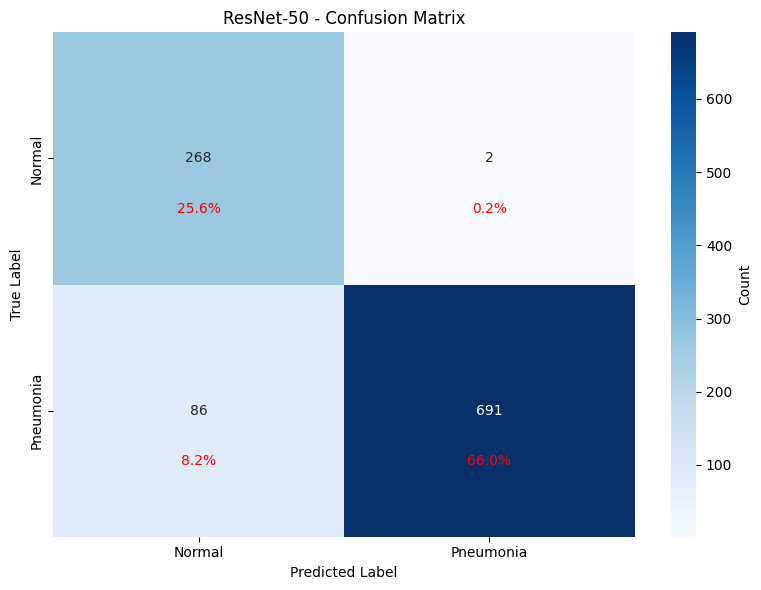


ViT Performance
Overall Precision: 0.9531
Overall Recall: 0.9532
Overall F1-Score: 0.9524

Class-specific metrics:
Normal (Class 0) - Precision: 0.9510, Recall: 0.8630, F1: 0.9049
Pneumonia (Class 1) - Precision: 0.9539, Recall: 0.9846, F1: 0.9690


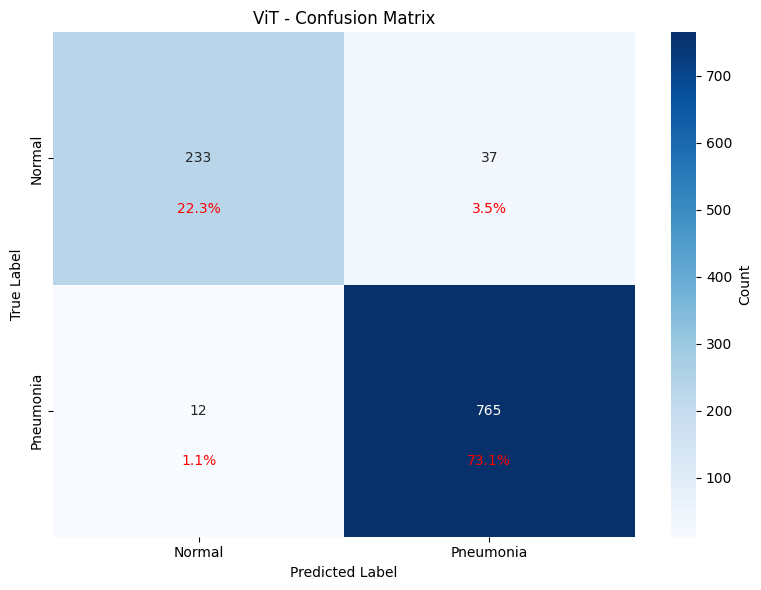

In [34]:
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, classification_report
import numpy as np


# Calc performance metrics precision, recall, F1-score
def evaluate_model_detailed(model, data_loader, model_name):

    model.eval()
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)

            # Handle different model outputs
            if hasattr(model, 'classifier') and 'ViT' in str(type(model)):
                outputs = model(images).logits
            else:
                outputs = model(images)

            _, predicted = torch.max(outputs, 1)

            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate metrics
    precision, recall, f1, support = precision_recall_fscore_support(
        all_labels, all_predictions, average=None, labels=[0, 1]
    )

    # Overall metrics
    precision_avg, recall_avg, f1_avg, _ = precision_recall_fscore_support(
        all_labels, all_predictions, average='weighted'
    )

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_predictions)

    print(f"\n{model_name} Performance")
    print(f"Overall Precision: {precision_avg:.4f}")
    print(f"Overall Recall: {recall_avg:.4f}")
    print(f"Overall F1-Score: {f1_avg:.4f}")

    print(f"\nClass-specific metrics:")
    print(f"Normal (Class 0) - Precision: {precision[0]:.4f}, Recall: {recall[0]:.4f}, F1: {f1[0]:.4f}")
    print(f"Pneumonia (Class 1) - Precision: {precision[1]:.4f}, Recall: {recall[1]:.4f}, F1: {f1[1]:.4f}")

    plot_confusion_matrix(cm, model_name)

    return {
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'precision_avg': precision_avg,
        'recall_avg': recall_avg,
        'f1_avg': f1_avg,
        'confusion_matrix': cm
    }

# Evaluate both models on validation set
resnet_metrics = evaluate_model_detailed(resnet, whole_val_loader, "ResNet-50")
vit_metrics = evaluate_model_detailed(vit, whole_val_loader, "ViT")